This colab file its focused on a system to auto-diagnose and differentiate between patients with Covid-19 ,Lung_Opacity ,Normal , & Viral Pneumonia due to the possible consequences for a patient, all diagnoses made should be checked with a medic or an expert opinion..

We decided to work on this field due to the Covid-19 pandemic and necesity to find a tool to help the sanitary authorities to discard patients with illnesses in cases with really similar simtoms.

The data set used in this code is from:https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database


The main article where its based this project is https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8872326/

We saw that they were using the same structure of data set Covid-19 ,Lung_Opacity ,Normal , & Viral Pneumonia but with less images in them so we thought that we could achieve better results than the 89% from CoroNet https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7274128/ applying the CoroNet architecture could obtain better results but we couldnt try it due to hardware constraint and colab gpu sessions constraints.

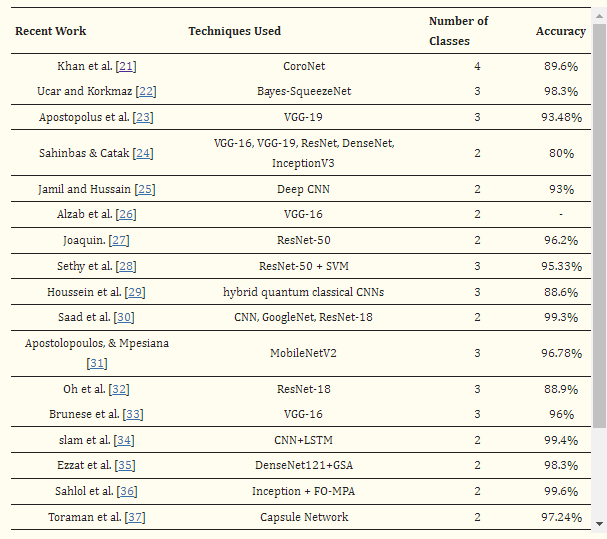



Because of those constraints we decided to use an Architecture really similar to the one recommended in the article:
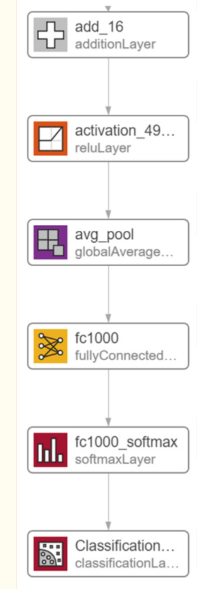

For Data Generation we Pandas library to create a Data Frame with the filenames and categories.

We decided to split the set into the classic 70% TRAIN  20% VALIDATION 10% TEST.

We saw that there is a big unbalance of data between the classes this problem its fixed on the model callbacks where we will computate and calculate the wheights .Thanks to that we can work with a greater amount of data.

Mounted at /content/gdrive
3616
10192
6012
1345


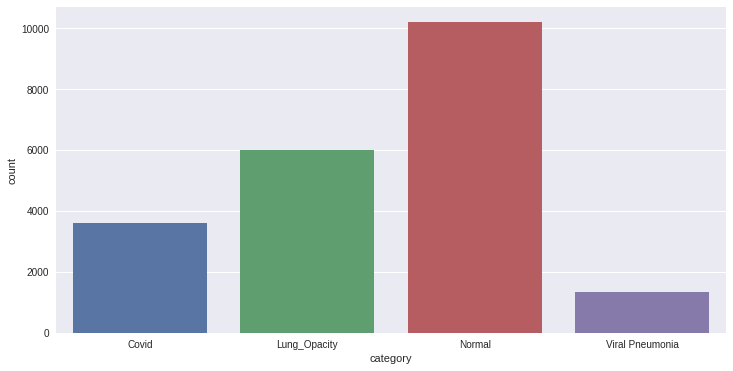

2115
4235
14815


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
import pandas as pd
# paths to covid and normal images
covid_path='/content/gdrive/MyDrive/Colab Notebooks/COVID-19_Radiography_Dataset/COVID/images'
Lung_path='/content/gdrive/MyDrive/Colab Notebooks/COVID-19_Radiography_Dataset/Lung_Opacity/images'
Pneumonia_path='/content/gdrive/MyDrive/Colab Notebooks/COVID-19_Radiography_Dataset/Viral Pneumonia/images'
Normal_path='/content/gdrive/MyDrive/Colab Notebooks/COVID-19_Radiography_Dataset/Normal/images'
# len covid images
print(len(os.listdir(covid_path)))

# len normal images
print(len(os.listdir(Normal_path)))

# len lungopacity images
print(len(os.listdir(Lung_path)))
# len Pneumonia images
print(len(os.listdir(Pneumonia_path)))

#We are going to obtain the paths of filenames from the differents classes and merge also adding their respectives categories

filenames = os.listdir(covid_path) + os.listdir(Lung_path)+ os.listdir(Normal_path)+ os.listdir(Pneumonia_path)
categories = []
for filename in filenames:
    category = filename.split('-')[0]
    if category == 'COVID':
        categories.append('Covid')
    elif category == 'Normal':
        categories.append('Normal')
    elif category == 'Lung_Opacity':
        categories.append('Lung_Opacity')
    elif category == 'Viral Pneumonia':
        categories.append('Viral Pneumonia')

for i in range(len(filenames)):
    if 'COVID' in filenames[i]:
        filenames[i] = os.path.join(covid_path, filenames[i])
    elif 'Normal' in filenames[i]:
        filenames[i] = os.path.join(Normal_path, filenames[i])
    elif 'Lung_Opacity' in filenames[i]:
        filenames[i] = os.path.join(Lung_path, filenames[i])
    elif 'Viral Pneumonia' in filenames[i]:
        filenames[i] = os.path.join(Pneumonia_path, filenames[i])

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
#plotting of the amount of images from each category

plt.style.use("seaborn")
plt.figure(figsize=(12,6))
sns.countplot(data = df.sort_values(by='category'), x ='category')
plt.show()

#CREATION OF THE TRAIN TEST AND VALID DATA WITH A RANDOM SEED
#Spliting first the data between training and test/valid with a 0.7 0.3 Ratio
train_data, test_valid_data = train_test_split(df, test_size=0.3, random_state = 42, shuffle=True, stratify=df['category'])
train_data = train_data.reset_index(drop=True)
test_valid_data = test_valid_data.reset_index(drop=True)

#Spliting second time, the data between valid and test with a 0.666 -0.333 Ratio corresponding aproximately to a 0.2 and 0.1 from the total
valid_data,test_data= train_test_split(test_valid_data, test_size=0.333, random_state = 42, shuffle=True, stratify=test_valid_data['category'])

print(len(test_data))
print(len(valid_data))
print(len(train_data))
test_data = test_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)


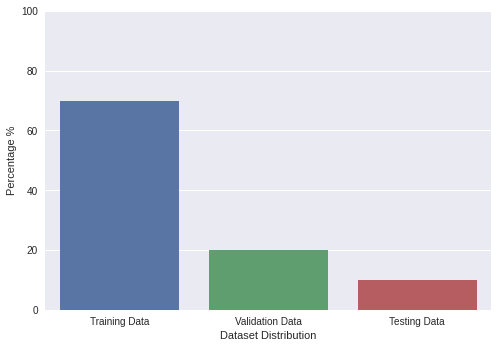

In [ ]:

#Plotting the Dataset split
tr_gp = round(len(train_data)/(len(test_data)+len(valid_data)+len(train_data))*100)
vld_gp = round(len(valid_data)/(len(test_data)+len(valid_data)+len(train_data))*100)
tst_gp = round(len(test_data)/(len(test_data)+len(valid_data)+len(train_data))*100)


df_gp = pd.DataFrame({
    'Training Data': eval(str(tr_gp)),
    'Validation Data': eval(str(vld_gp)),
    'Testing Data': eval(str(tst_gp))
}, index=[0]
)

df_gp=df_gp.T

plt.style.use("seaborn")

gp= sns.barplot(data = df_gp, x = ['Training Data', 'Validation Data', 'Testing Data'],y=[tr_gp,vld_gp,tst_gp])
gp.set(xlabel ="Dataset Distribution", ylabel = "Percentage %")
plt.ylim(0, 100)
plt.show()

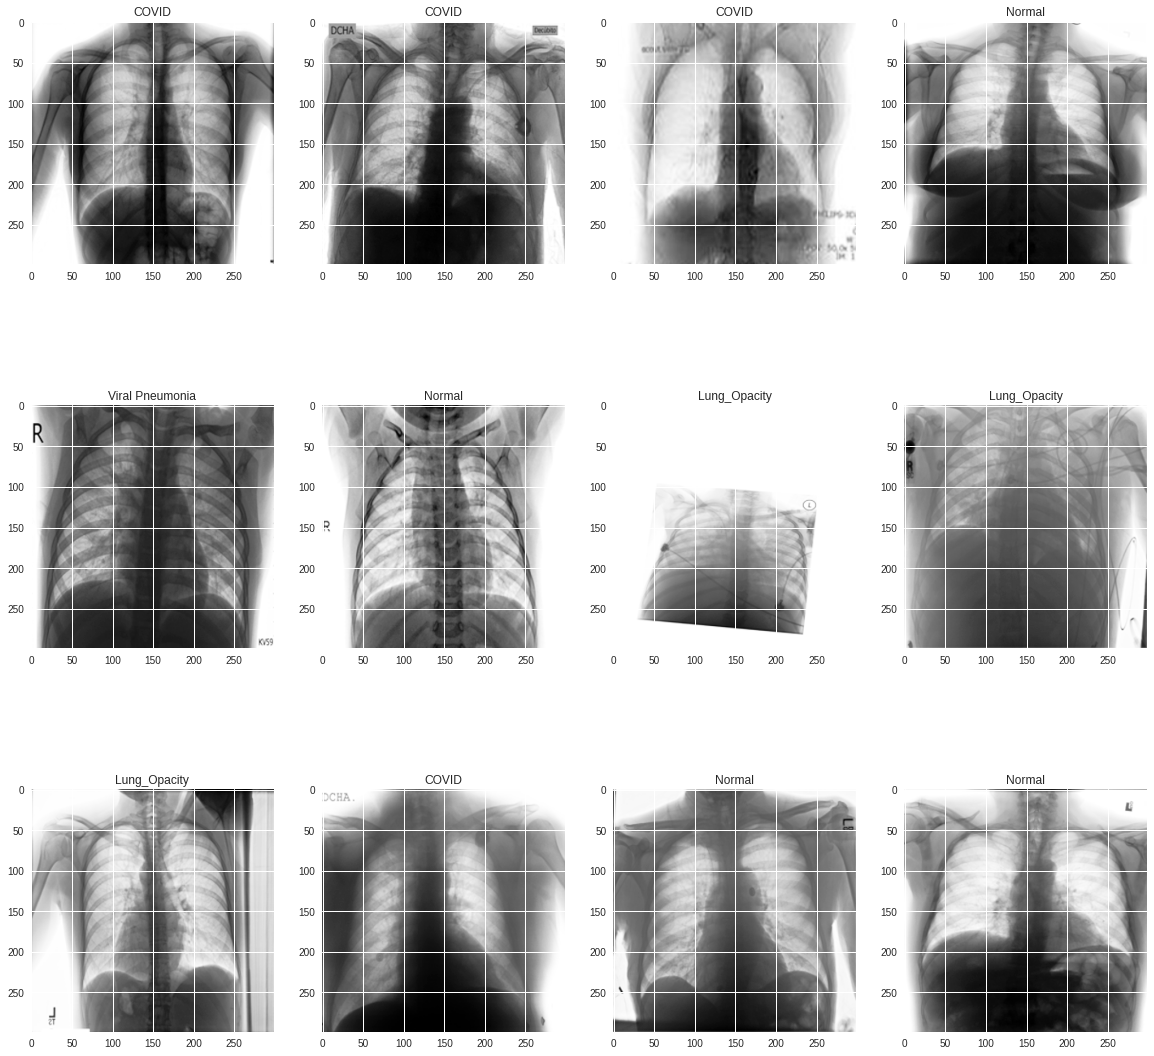

In [ ]:
sample_images = train_data.sample(12)["filename"]
plt.figure(figsize=(20,20))
for i,path in enumerate(sample_images) :
    plt.subplot(3,4,i+1)
    plt.imshow(plt.imread(path))
    plt.title(path.split("/")[-1].split("-")[0])

In [ ]:
import random
import cv2
import numpy as np

#Just creates an np array of images in order to fit the Data generators
samples = []
random.seed(4)
random.shuffle(filenames)
files=filenames[0:100]
for filename in files:
  im = cv2.imread(filename)
  samples.append(np.asarray(im))

Data is Generated thanks to keras Image Data generator. The data its Augmented and tranformed with 0 mean and 1 std

In [ ]:
from keras_preprocessing.image import ImageDataGenerator
#Creating the Data Generator we apply std normalization and 0 mean to all the data also randomly images will be rotated and flipped horizontally
train_data_gen=ImageDataGenerator(#rescale=1./255,
                                  featurewise_center=True,#Set input mean to 0 over the dataset.
                                  featurewise_std_normalization=True, #Divide inputs by std of the dataset.
                                  rotation_range=20,width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  horizontal_flip=True)

#We use the previously samples to calculate their mean and std to work and gen the data
train_data_gen.fit(samples)
train = train_data_gen.flow_from_dataframe(train_data,
                                           class_mode = 'categorical',
                                           x_col='filename',
                                           y_col='category',
                                           batch_size=64,
                                           target_size=(224,224))
test_data_gen = train_data_gen
valid = test_data_gen.flow_from_dataframe(valid_data,x_col='filename',y_col='category',target_size=(224,224),class_mode = 'categorical',shuffle=True,batch_size=64)
test = test_data_gen.flow_from_dataframe(test_data ,x_col='filename',y_col='category',target_size=(224,224),class_mode = 'categorical',shuffle=True,batch_size=64)

Found 14815 validated image filenames belonging to 4 classes.
Found 4235 validated image filenames belonging to 4 classes.
Found 2115 validated image filenames belonging to 4 classes.


Creation of the ResNet50 based model,We dont load any weights( we tried with imagenets weights and results were around 60-70% really bad performance).

Also we decide to use Adam optimizer with 0.001 of learning rate and focused on accuracy with a loss function of croos entroppy

In [ ]:

from google.colab import drive
drive.mount('/content/gdrive')

import random
import numpy as np
import tensorflow as tf
import torchvision
from tensorflow import keras
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import os
import shutil
from tensorflow.keras.applications.resnet50 import ResNet50


print(train.class_indices)
print(test)
#We create ResNet50
base_model = ResNet50(input_shape= (224,224,3), weights = None, include_top=False) #if weights were from Imagenet we had to frezze the gradients from the under layers
"""for layer in base_model.layers:
    layer.trainable=False
"""

x=base_model.output
x=GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
out=Dense(4,activation='softmax')(x)

Rest_NetModel=Model(inputs=base_model.input,outputs=out)

Rest_NetModel.summary()
Rest_NetModel.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
{'Covid': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']          

We decided to train the model for 35 epochs in here we used only 1 of this callbacks but we recomend the use of them during the exploring and training of the data

early: Stops the learning process when identifies that results are not improving

lr_reduction:The most important one reduce automatically the lr when it identifies a plateau feature: sinthom of overfitting

cp_callback: saves the best weights in the path we want/ thanks to this we can restart training from that epoch also can be set instead of best to a cadency of epochs

Also here we fix the unbalance problems thanks to compute_class_weight

In [ ]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras_preprocessing.image import ImageDataGenerator

#checkpoint_path = "/content/gdrive/MyDrive/Colab Notebooks/Savefiles/Checkpoints/checkpoint{epoch:02d}.hdf5"
#early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=8)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 4,verbose=1,factor=0.4, min_lr=0.00002)
"""
this callback its used for saving the model we recommend to you but affects the train speed of the model
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=0,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
"""
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight(class_weight = "balanced",classes = np.unique(train.classes),y = train.classes)
class_weights = dict(zip(np.unique(train.classes),weights))

callbacks_list = [# early,
                  learning_rate_reduction
                  #,cp_callback
                  ]

print(len(train))
print(len(valid))
hist = Rest_NetModel.fit(train, epochs=35,steps_per_epoch= len(train), validation_data=valid,class_weight=class_weights,validation_steps= len(valid),callbacks=callbacks_list)
Rest_NetModel.save('/content/gdrive/MyDrive/Colab Notebooks/Savefiles/Models/firsttrainmodel.h5')
np.save('/content/gdrive/MyDrive/Colab Notebooks/Savefiles/historytrain1.npy',hist.history)


232
67
Epoch 1/35
232/232 [==============================] - 280s 1s/step - loss: 0.9916 - accuracy: 0.5469 - val_loss: 2.4923 - val_accuracy: 0.3107 - lr: 0.0010
Epoch 2/35
232/232 [==============================] - 276s 1s/step - loss: 0.8088 - accuracy: 0.6210 - val_loss: 9.8812 - val_accuracy: 0.3445 - lr: 0.0010
Epoch 3/35
232/232 [==============================] - 275s 1s/step - loss: 0.6626 - accuracy: 0.6837 - val_loss: 0.8209 - val_accuracy: 0.6961 - lr: 0.0010
Epoch 4/35
232/232 [==============================] - 275s 1s/step - loss: 0.5947 - accuracy: 0.7077 - val_loss: 2.3642 - val_accuracy: 0.3865 - lr: 0.0010
Epoch 5/35
232/232 [==============================] - 275s 1s/step - loss: 0.5480 - accuracy: 0.7442 - val_loss: 23.9005 - val_accuracy: 0.2571 - lr: 0.0010
Epoch 6/35
232/232 [==============================] - 275s 1s/step - loss: 0.5163 - accuracy: 0.7589 - val_loss: 3.6252 - val_accuracy: 0.5672 - lr: 0.0010
Epoch 7/35
232/232 [==============================] - ET

After training we obtain:

train performance -train accuracy: 0.9396

validation performance - val_accuracy: 0.9218

test performance  - val_test: 0.9234


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
from keras.models import  load_model

new_model = load_model('/content/gdrive/MyDrive/Colab Notebooks/Savefiles/Models/firsttrainmodel.h5')
test_accu = new_model.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
34/34 [==============================] - 1021s 31s/step - loss: 0.1986 - accuracy: 0.9253
The testing accuracy is : 92.52955317497253 %


In [ ]:
hist= np.load('/content/gdrive/MyDrive/Colab Notebooks/Savefiles/historytrain1.npy',allow_pickle='TRUE').item()


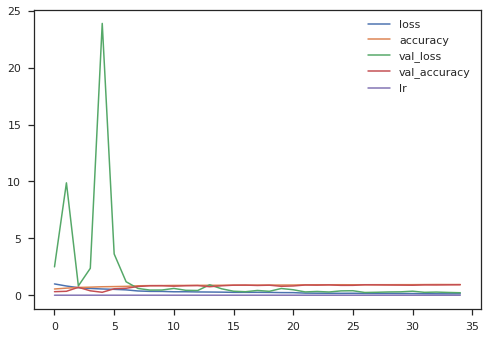

In [ ]:
import pandas as pd
pd.DataFrame(hist).plot()

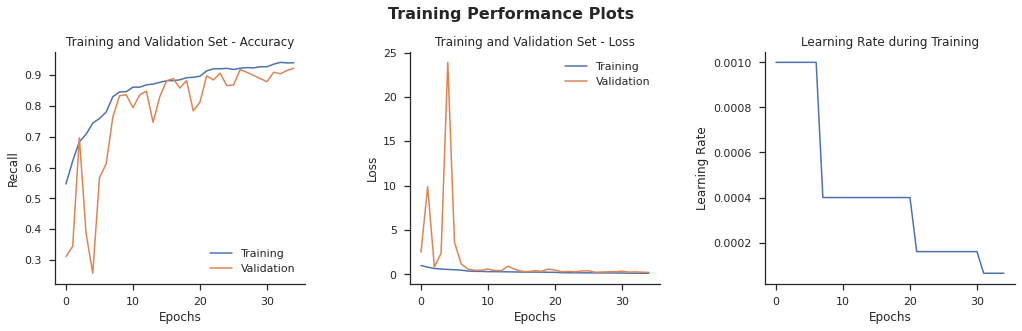

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, axarr = plt.subplots(1,3, figsize=(15,5),sharex=True)

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)

historyDF = pd.DataFrame.from_dict(hist)

ax = sns.lineplot(x =historyDF.index, y = hist['accuracy'],ax=axarr[0],label="Training");
ax = sns.lineplot(x =historyDF.index, y = hist['val_accuracy'],ax=axarr[0],label="Validation");
ax.set_ylabel('Recall')

ax = sns.lineplot(x =historyDF.index, y = hist['loss'],ax=axarr[1],label="Training");
ax = sns.lineplot(x =historyDF.index, y = hist['val_loss'],ax=axarr[1],label="Validation");
ax.set_ylabel('Loss')
ax = sns.lineplot(x =historyDF.index, y = hist['lr'],ax=axarr[2]);
ax.set_ylabel('Learning Rate')
axarr[0].set_title("Training and Validation Set - Accuracy")
axarr[1].set_title("Training and Validation Set - Loss")
axarr[2].set_title("Learning Rate during Training")

for ax in axarr:
    ax.set_xlabel('Epochs')

plt.suptitle('Training Performance Plots',fontsize=16, weight = 'bold');
fig.tight_layout(pad=3.0)
plt.show()

In this graphics we can see 3 important  consecuences. All explained by the learning Rate reduction showed in the third graphic.

As we see at the end of the 7th epoch the callback detected that Val accuracy was getting a plateau form which means that detects that its stopping learning and we can fall in an overfitting part when we improve train accuracy and loss train but not validation parametres.

So we can explain the loss increasement each time we had a change in our learning rates also we can detect how in Accuracy and loos charts the tendecy of each set its going to the same form wich is great.

Also we can observe that the changes of the lr doesn't impact our performance so strongly once we pass from 0.001 to 0.0004 .So we can supose that for an initial learning rate 0.001 was to high.

Maybe a lr between 0.0005-0.0003 can be great values for NN that does not change the lr automatically.  

34


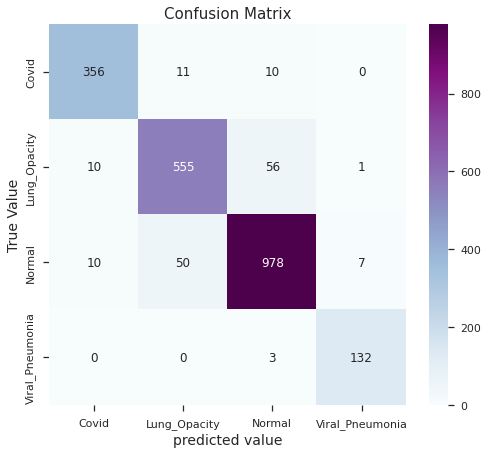

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
all_label_names=['Covid', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia']
def plot_cm(labels,pre):
    conf_numpy = confusion_matrix(labels,pre)#Draw confusion matrix based on actual and predicted values
    conf_df = pd.DataFrame(conf_numpy,index=all_label_names,columns=all_label_names)#Put data and all_label_names made into DataFrame s
    plt.figure(figsize=(8,7))

    sns.heatmap(conf_df,annot=True,fmt="d",cmap="BuPu")#Draw data as confusion matrix
    plt.title('Confusion Matrix',fontsize = 15)
    plt.ylabel('True Value',fontsize = 14)
    plt.xlabel('predicted value',fontsize = 14)
    plt.show()
c=0
test_pre = []
test_label = []
tam=len(test)
print(len(test))
for images,labels in test:
  for image,label in zip(images,labels):
        img_array = tf.expand_dims(image,0)#Add a common dimension
        pre = new_model.predict(img_array)#Forecast results
        test_pre.append(all_label_names[np.argmax(pre)])#Pass predictions into the list
        test_label.append(all_label_names[np.argmax(label)])#Pass real results into the list
  if c==tam:
          break
  c+=1
plot_cm(test_label,test_pre)#Draw confusion matrix


#From 2179 IMAGES
#2009 92.1982% GOOD PREDICTIONS
#170   7.8017% BAD PREDICTIONS

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_pre,test_label,target_names=all_label_names))

                 precision    recall  f1-score   support

          Covid       0.94      0.95      0.95       376
   Lung_Opacity       0.89      0.90      0.90       616
         Normal       0.94      0.93      0.93      1047
Viral_Pneumonia       0.98      0.94      0.96       140

       accuracy                           0.93      2179
      macro avg       0.94      0.93      0.93      2179
   weighted avg       0.93      0.93      0.93      2179



### We are predicting here with the utilization of test data




---
```
 This will test us what is the class of input image and what the model has predicted it
```

---



---



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


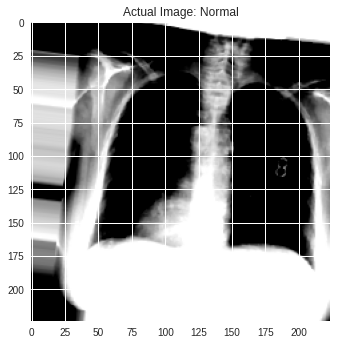

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The Image: -> Normal  predicted class is: -> Normal  with confidence:  97.39999999999999 %
so far 1 have been identified correctly and  0  have been identified incorrectly


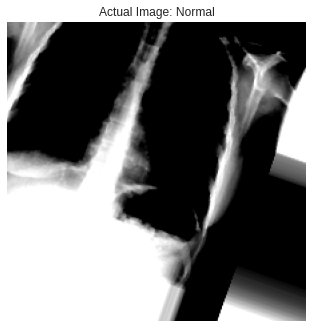

The Image: -> Normal  predicted class is: -> Normal  with confidence:  99.8 %
so far 2 have been identified correctly and  0  have been identified incorrectly


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


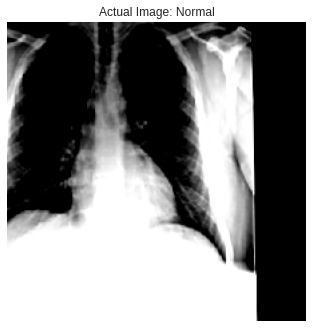

The Image: -> Normal  predicted class is: -> Normal  with confidence:  95.7 %
so far 3 have been identified correctly and  0  have been identified incorrectly


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


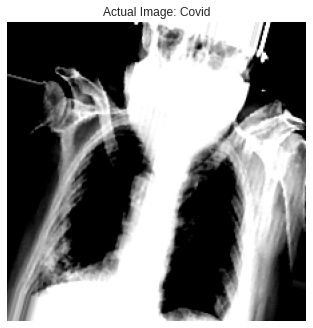

The Image: -> Covid  predicted class is: -> Covid  with confidence:  99.7 %
so far 4 have been identified correctly and  0  have been identified incorrectly


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


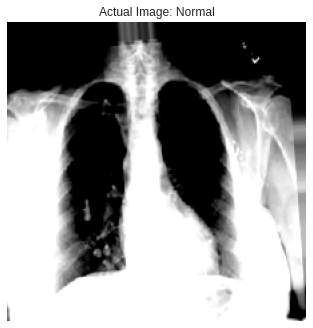

The Image: -> Normal  predicted class is: -> Normal  with confidence:  86.0 %
so far 5 have been identified correctly and  0  have been identified incorrectly


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


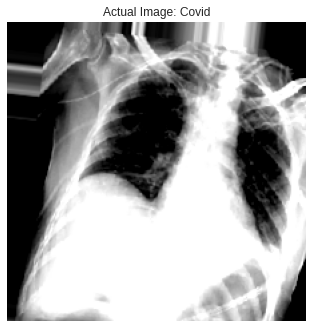

The Image: -> Covid  predicted class is: -> Covid  with confidence:  99.0 %
so far 6 have been identified correctly and  0  have been identified incorrectly


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


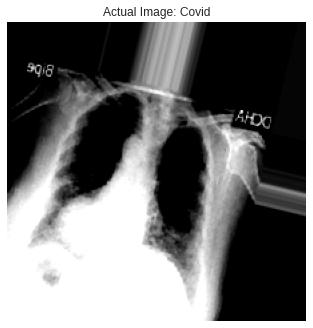

The Image: -> Covid  predicted class is: -> Covid  with confidence:  100.0 %
so far 7 have been identified correctly and  0  have been identified incorrectly


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


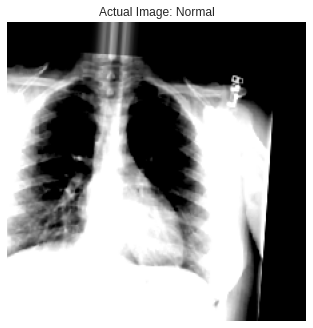

The Image: -> Normal  predicted class is: -> Normal  with confidence:  66.4 %
so far 8 have been identified correctly and  0  have been identified incorrectly


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


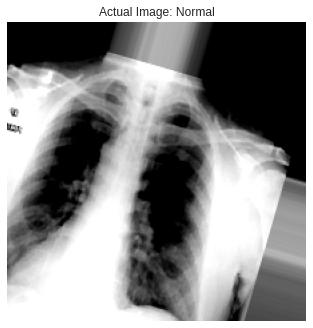

The Image: -> Normal  predicted class is: -> Normal  with confidence:  60.099999999999994 %
so far 9 have been identified correctly and  0  have been identified incorrectly


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


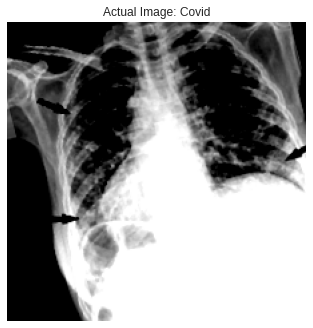

The Image: -> Covid  predicted class is: -> Lung_Opacity  with confidence:  63.3 %
so far 9 have been identified correctly and  1  have been identified incorrectly


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


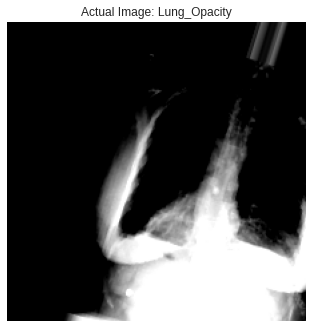

The Image: -> Lung_Opacity  predicted class is: -> Normal  with confidence:  90.0 %
so far 9 have been identified correctly and  2  have been identified incorrectly


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


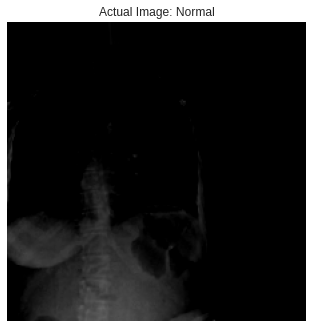

The Image: -> Normal  predicted class is: -> Normal  with confidence:  80.9 %
so far 10 have been identified correctly and  2  have been identified incorrectly


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


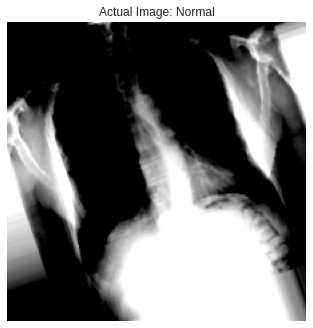

The Image: -> Normal  predicted class is: -> Normal  with confidence:  99.4 %
so far 11 have been identified correctly and  2  have been identified incorrectly


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


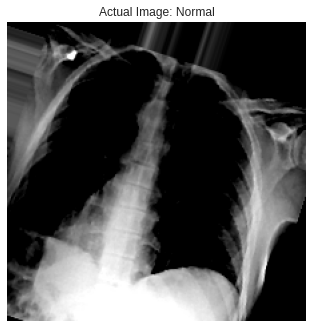

The Image: -> Normal  predicted class is: -> Lung_Opacity  with confidence:  52.400000000000006 %
so far 11 have been identified correctly and  3  have been identified incorrectly


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


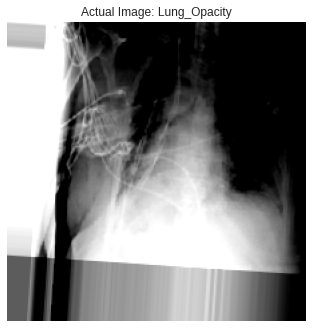

The Image: -> Lung_Opacity  predicted class is: -> Lung_Opacity  with confidence:  98.7 %
so far 12 have been identified correctly and  3  have been identified incorrectly


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


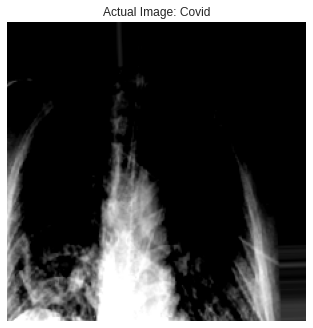

The Image: -> Covid  predicted class is: -> Covid  with confidence:  100.0 %
so far 13 have been identified correctly and  3  have been identified incorrectly


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


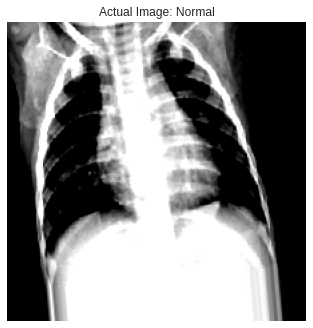

The Image: -> Normal  predicted class is: -> Normal  with confidence:  99.7 %
so far 14 have been identified correctly and  3  have been identified incorrectly


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


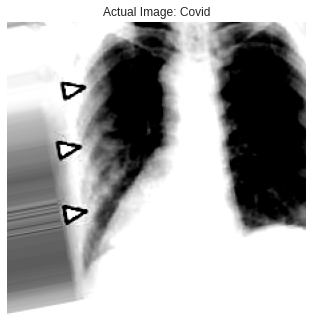

The Image: -> Covid  predicted class is: -> Covid  with confidence:  100.0 %
so far 15 have been identified correctly and  3  have been identified incorrectly


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


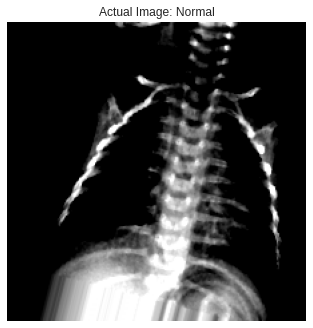

The Image: -> Normal  predicted class is: -> Normal  with confidence:  99.7 %
so far 16 have been identified correctly and  3  have been identified incorrectly


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


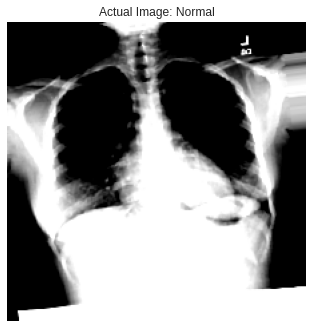

The Image: -> Normal  predicted class is: -> Normal  with confidence:  98.4 %
so far 17 have been identified correctly and  3  have been identified incorrectly


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


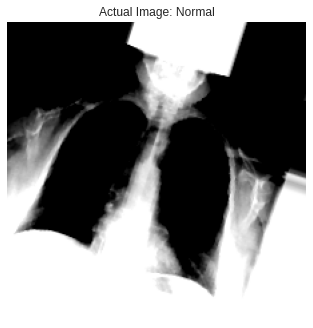

The Image: -> Normal  predicted class is: -> Normal  with confidence:  99.1 %
so far 18 have been identified correctly and  3  have been identified incorrectly


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


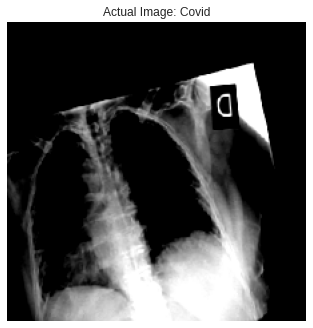

The Image: -> Covid  predicted class is: -> Covid  with confidence:  96.8 %
so far 19 have been identified correctly and  3  have been identified incorrectly


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


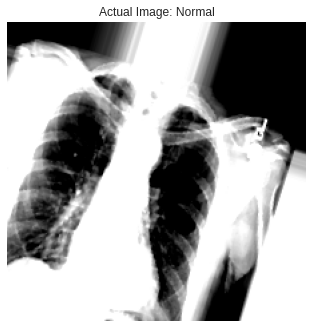

The Image: -> Normal  predicted class is: -> Lung_Opacity  with confidence:  72.5 %
so far 19 have been identified correctly and  4  have been identified incorrectly


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


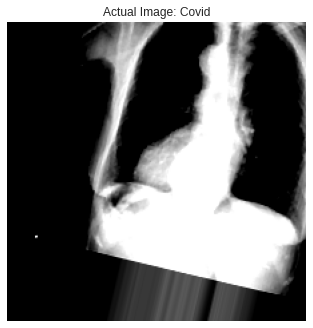

The Image: -> Covid  predicted class is: -> Covid  with confidence:  99.9 %
so far 20 have been identified correctly and  4  have been identified incorrectly


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


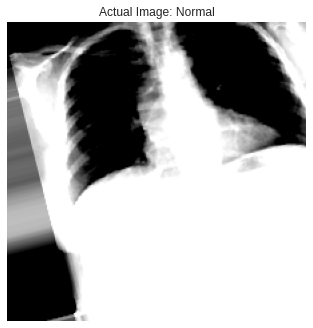

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The Image: -> Normal  predicted class is: -> Normal  with confidence:  98.5 %
so far 21 have been identified correctly and  4  have been identified incorrectly


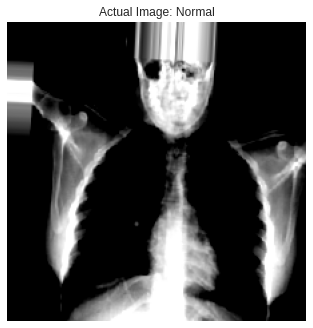

The Image: -> Normal  predicted class is: -> Normal  with confidence:  99.2 %
so far 22 have been identified correctly and  4  have been identified incorrectly


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


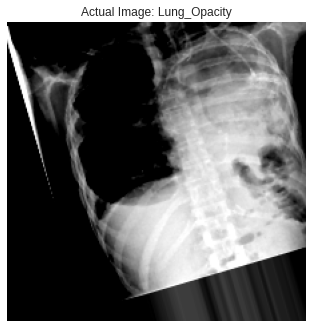

The Image: -> Lung_Opacity  predicted class is: -> Lung_Opacity  with confidence:  99.8 %
so far 23 have been identified correctly and  4  have been identified incorrectly


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


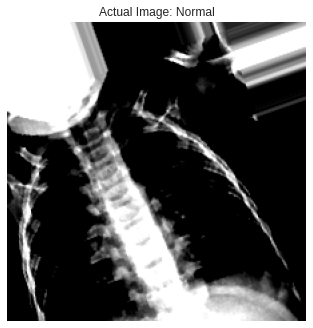

The Image: -> Normal  predicted class is: -> Normal  with confidence:  67.30000000000001 %
so far 24 have been identified correctly and  4  have been identified incorrectly


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


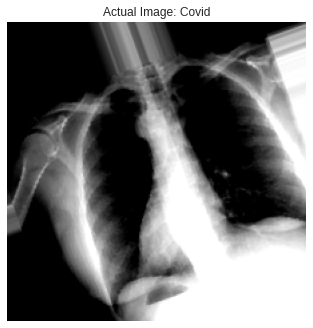

The Image: -> Covid  predicted class is: -> Covid  with confidence:  99.9 %
so far 25 have been identified correctly and  4  have been identified incorrectly


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


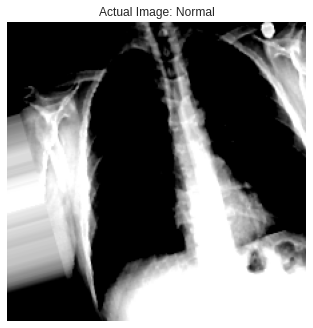

The Image: -> Normal  predicted class is: -> Normal  with confidence:  99.3 %
so far 26 have been identified correctly and  4  have been identified incorrectly


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


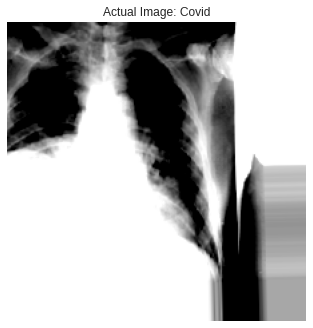

The Image: -> Covid  predicted class is: -> Covid  with confidence:  100.0 %
so far 27 have been identified correctly and  4  have been identified incorrectly


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


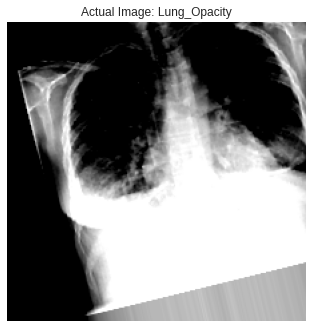

The Image: -> Lung_Opacity  predicted class is: -> Lung_Opacity  with confidence:  85.2 %
so far 28 have been identified correctly and  4  have been identified incorrectly


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


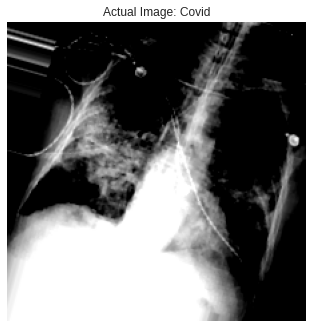

The Image: -> Covid  predicted class is: -> Covid  with confidence:  79.0 %
so far 29 have been identified correctly and  4  have been identified incorrectly


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


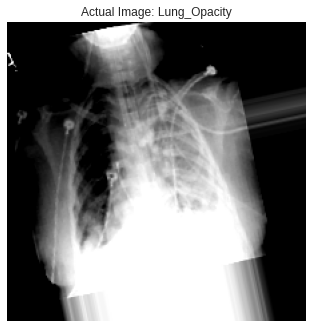

The Image: -> Lung_Opacity  predicted class is: -> Lung_Opacity  with confidence:  98.6 %
so far 30 have been identified correctly and  4  have been identified incorrectly


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


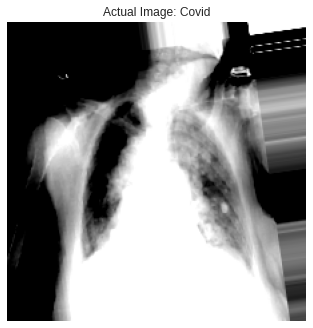

The Image: -> Covid  predicted class is: -> Covid  with confidence:  98.2 %
so far 31 have been identified correctly and  4  have been identified incorrectly


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


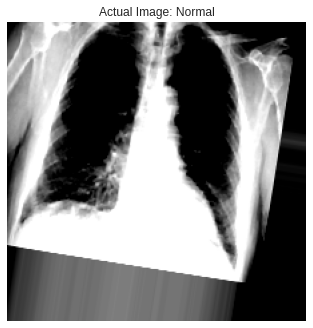

The Image: -> Normal  predicted class is: -> Normal  with confidence:  89.3 %
so far 32 have been identified correctly and  4  have been identified incorrectly


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


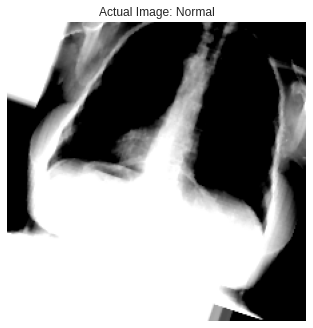

The Image: -> Normal  predicted class is: -> Normal  with confidence:  99.3 %
so far 33 have been identified correctly and  4  have been identified incorrectly


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


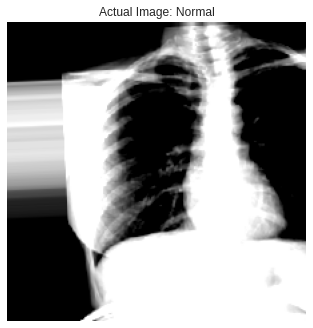

The Image: -> Normal  predicted class is: -> Normal  with confidence:  97.1 %
so far 34 have been identified correctly and  4  have been identified incorrectly


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


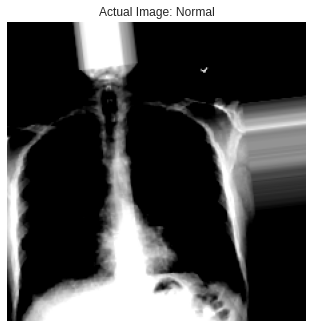

The Image: -> Normal  predicted class is: -> Normal  with confidence:  99.7 %
so far 35 have been identified correctly and  4  have been identified incorrectly


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


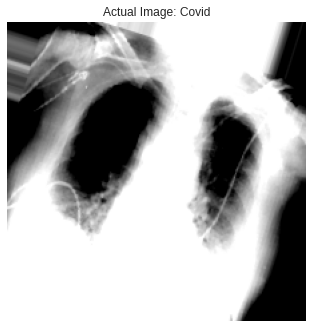

The Image: -> Covid  predicted class is: -> Covid  with confidence:  100.0 %
so far 36 have been identified correctly and  4  have been identified incorrectly


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


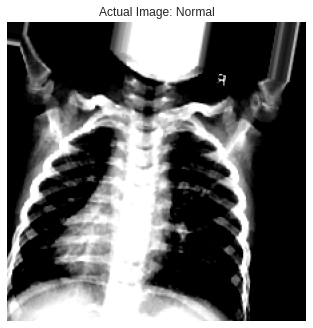

The Image: -> Normal  predicted class is: -> Normal  with confidence:  100.0 %
so far 37 have been identified correctly and  4  have been identified incorrectly


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


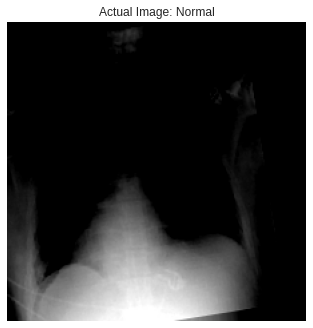

The Image: -> Normal  predicted class is: -> Normal  with confidence:  70.7 %
so far 38 have been identified correctly and  4  have been identified incorrectly


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


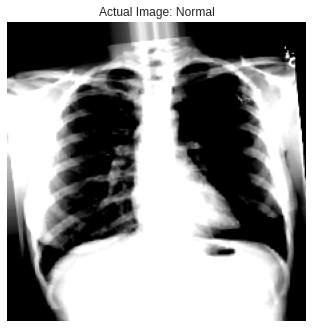

The Image: -> Normal  predicted class is: -> Normal  with confidence:  95.8 %
so far 39 have been identified correctly and  4  have been identified incorrectly


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


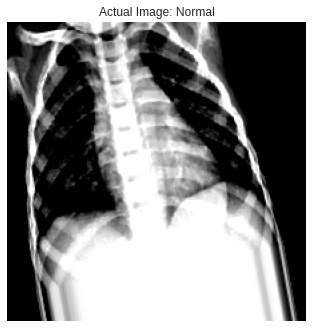

The Image: -> Normal  predicted class is: -> Normal  with confidence:  99.9 %
so far 40 have been identified correctly and  4  have been identified incorrectly


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


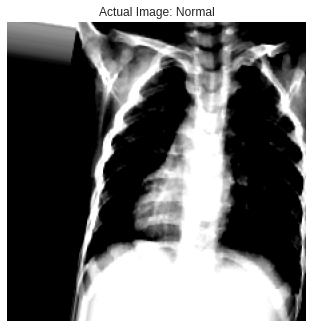

The Image: -> Normal  predicted class is: -> Normal  with confidence:  99.0 %
so far 41 have been identified correctly and  4  have been identified incorrectly


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


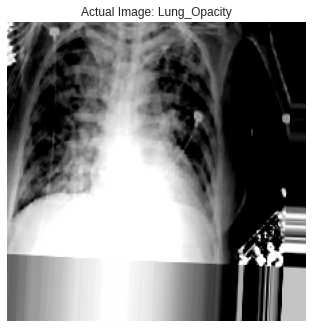

The Image: -> Lung_Opacity  predicted class is: -> Lung_Opacity  with confidence:  100.0 %
so far 42 have been identified correctly and  4  have been identified incorrectly


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


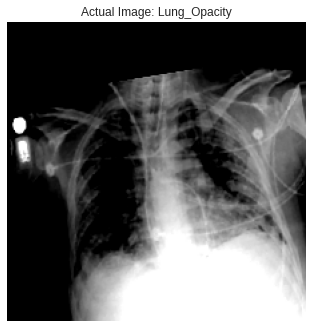

The Image: -> Lung_Opacity  predicted class is: -> Lung_Opacity  with confidence:  97.2 %
so far 43 have been identified correctly and  4  have been identified incorrectly


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


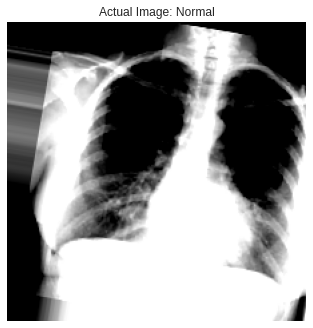

The Image: -> Normal  predicted class is: -> Normal  with confidence:  77.60000000000001 %
so far 44 have been identified correctly and  4  have been identified incorrectly


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


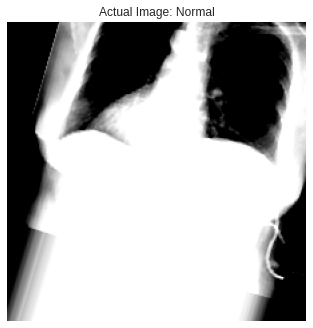

The Image: -> Normal  predicted class is: -> Normal  with confidence:  90.60000000000001 %
so far 45 have been identified correctly and  4  have been identified incorrectly


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


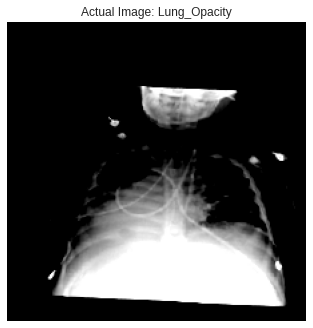

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The Image: -> Lung_Opacity  predicted class is: -> Lung_Opacity  with confidence:  98.2 %
so far 46 have been identified correctly and  4  have been identified incorrectly


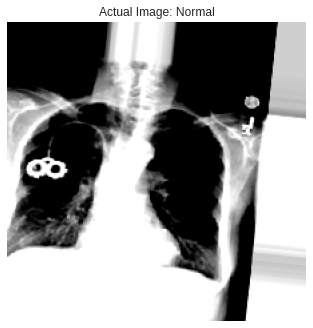

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The Image: -> Normal  predicted class is: -> Normal  with confidence:  84.2 %
so far 47 have been identified correctly and  4  have been identified incorrectly


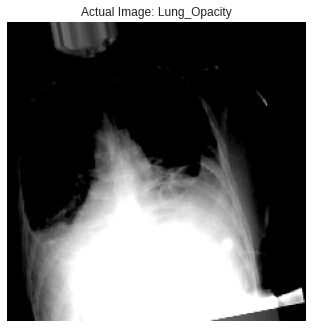

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The Image: -> Lung_Opacity  predicted class is: -> Lung_Opacity  with confidence:  100.0 %
so far 48 have been identified correctly and  4  have been identified incorrectly


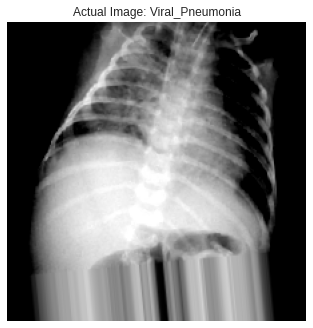

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The Image: -> Viral_Pneumonia  predicted class is: -> Viral_Pneumonia  with confidence:  99.9 %
so far 49 have been identified correctly and  4  have been identified incorrectly


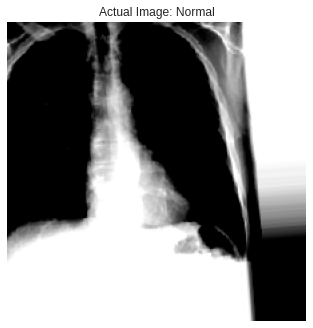

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The Image: -> Normal  predicted class is: -> Normal  with confidence:  95.7 %
so far 50 have been identified correctly and  4  have been identified incorrectly


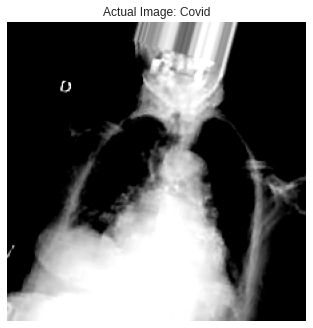

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The Image: -> Covid  predicted class is: -> Covid  with confidence:  99.5 %
so far 51 have been identified correctly and  4  have been identified incorrectly


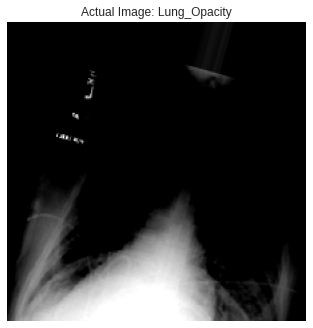

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The Image: -> Lung_Opacity  predicted class is: -> Lung_Opacity  with confidence:  99.9 %
so far 52 have been identified correctly and  4  have been identified incorrectly


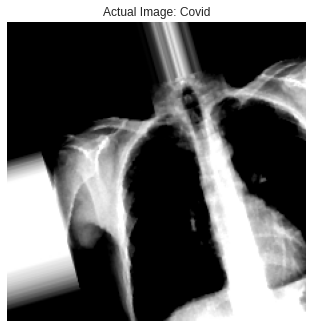

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The Image: -> Covid  predicted class is: -> Covid  with confidence:  94.6 %
so far 53 have been identified correctly and  4  have been identified incorrectly


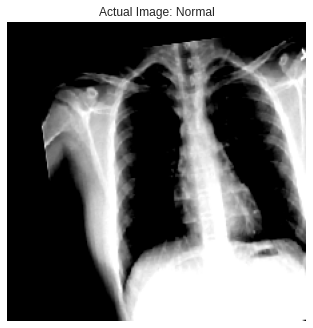

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The Image: -> Normal  predicted class is: -> Normal  with confidence:  98.9 %
so far 54 have been identified correctly and  4  have been identified incorrectly


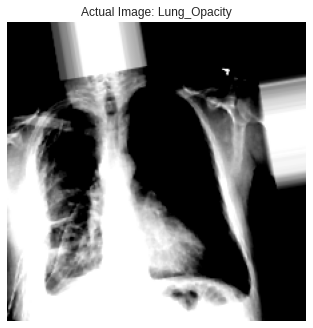

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The Image: -> Lung_Opacity  predicted class is: -> Lung_Opacity  with confidence:  99.6 %
so far 55 have been identified correctly and  4  have been identified incorrectly


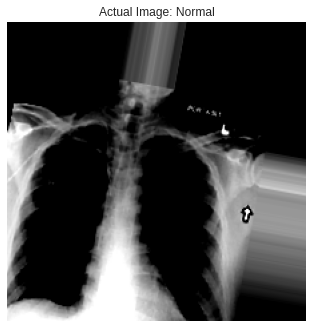

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The Image: -> Normal  predicted class is: -> Normal  with confidence:  96.8 %
so far 56 have been identified correctly and  4  have been identified incorrectly


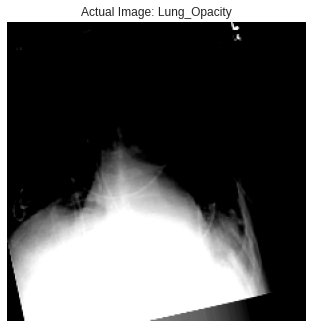

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The Image: -> Lung_Opacity  predicted class is: -> Lung_Opacity  with confidence:  100.0 %
so far 57 have been identified correctly and  4  have been identified incorrectly


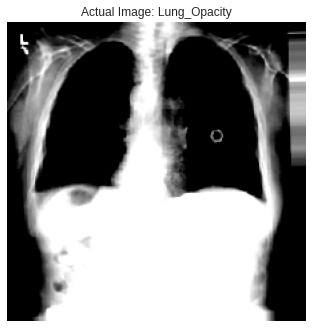

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The Image: -> Lung_Opacity  predicted class is: -> Lung_Opacity  with confidence:  55.300000000000004 %
so far 58 have been identified correctly and  4  have been identified incorrectly


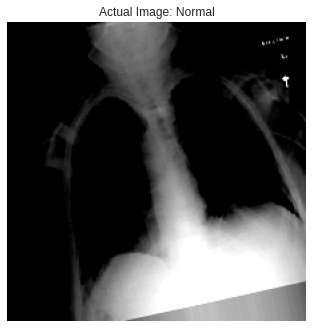

The Image: -> Normal  predicted class is: -> Lung_Opacity  with confidence:  76.3 %
so far 58 have been identified correctly and  5  have been identified incorrectly


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


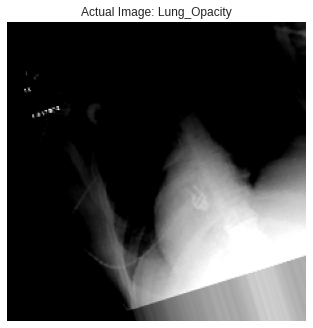

The Image: -> Lung_Opacity  predicted class is: -> Lung_Opacity  with confidence:  55.60000000000001 %
so far 59 have been identified correctly and  5  have been identified incorrectly


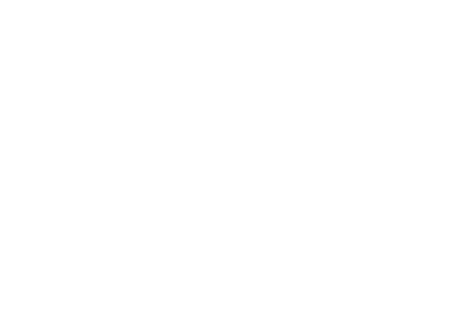

In [ ]:

all_label_names=['Covid', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia']
g=0
h=0
k=0
#kill=len(test)
kill=0 # it will only print 64 images (random)
for igms, lbals  in test:
    for igm,lbal in zip(igms,lbals):
        img_arr = np.array(igm)
        img_arr = img_arr.reshape(1, img_arr.shape[0], img_arr.shape[1], img_arr.shape[2])
        y_predct = new_model.predict(img_arr)
        y_act = all_label_names[np.argmax(lbal)]
        plt.imshow(igm)
        plt.title("Actual Image: "+y_act)
        plt.show()
        plt.axis("off")

        for ind,prob in enumerate(y_predct):
            ind=np.argmax(prob) # the index of the max of the probability of four classes
            klass=all_label_names[ind]    # transforming the index to class name
            problty=format(prob[ind],'.3f')
            print('The Image: ->',y_act, ' , predicted class is: ->', klass,' , with confidence: ',float(problty)*100, '%')

        if y_act==klass:
            g+=1
        else:
            h+=1
        print("so far",g,"have been identified correctly and ",h," have been identified incorrectly")

    if k==kill:
        break
    k+=1
